In [1]:
# -*- coding: utf-8 -*-
"""
@author: Etienne Kras
"""
# imports 
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import geopandas as gpd
import os
import geemap
# import leafmap
# import math
import geojson
# import datetime
import time
import rasterio
import sys
import ee
ee.Initialize()

from tqdm.notebook import tqdm_notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable
from osgeo import gdal, osr
# from dateutil.relativedelta import relativedelta
# from geojson import Feature, FeatureCollection, dump
# from shapely.geometry import Polygon, LineString, MultiLineString, Point
# from scipy import stats, interpolate
from google.cloud import storage

# coordinate conversions
# SR4326 = osr.SpatialReference()
# SR4326.ImportFromEPSG(4326)     # WGS84 / Geographic
# SR3857 = osr.SpatialReference()
# SR3857.ImportFromEPSG(3857)     # WGS84 / Pseudo-Mercator
# ct_4326_to_3857 = osr.CoordinateTransformation(SR4326, SR3857)
# ct_3857_to_4326 = osr.CoordinateTransformation(SR3857, SR4326)

# custom functionality import without requirement to pip install package
# local_path = r"C:\Users\kras\Documents\GitHub\ee-packages-py"  # path to local GitHub clone
# sys.path.append(local_path)
# from eepackages.utils import hillshadeRGB

%matplotlib widget

# Project specific toggles

In [2]:
# acknowledgements & code references:
# https://github.com/openearth/eo-bathymetry/
# https://github.com/openearth/eo-bathymetry-functions/
# https://github.com/gee-community/ee-packages-py

# paper with info:
# https://reader.elsevier.com/reader/sd/pii/S2352938521000355?token=5BC1DEF1C39AC44842C99BF745E62B442099F6E166ACD9456EF170FA5A7EA0EA5A90E442318C4B4343C24F70A9AF480D&originRegion=eu-west-1&originCreation=20230227093253

# inspiration
# Can Gio SDB feasibility

In [3]:
# project toggles
main_fol = r"p:/11208561-he11-abu-dhabi/6_satellite_bathymetry" # name of the main local folder 
bucket = "hudayriat-sdb" # name of the Google Cloud Storage bucket to store files in the cloud
credential_file = r"Z:/OneDrive - Stichting Deltares/Documents/3. General/keys/jip-calm-0162576b9743.json" # Cloud Storage credential key
input_fol = "Proxy" # name of the input folder
output_fol = "SDB" # name of the output folder
project_name = "Hudayriat" # name of the project AoI

# composite image toggles 
scale = 10  # input resolution of the image [m]
zoom_level = "" # specify zoom level or leave empty in case of an arbitrary polygons

# load google credentials, if specified
if not credential_file == "":  
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(credential_file)

# tidal information (project input)
# TODO: incorporate GTSM or FES2014 to get tidal indicators (LAT, MLLW, (MHLW), MSL, (MLHW), MHHW, HAT) etc. 
# note, mismatch with BlueEarthData tidal indicators from GTSM (range is ~0.97 m iso ~2.4 m as specified in project input)
tide_inds = [-1.14, -0.64, -0.14, 0.06, 0.26, 0.76, 1.26] # m, [LAT, MLLW, (MHLW), MSL, (MLHW), MHHW, HAT]

# Loading pre-processed files (API)

In [29]:
# DIRECTLY FROM THE CLOUD

# get file names
client = storage.Client()
ls = [blob for blob in client.list_blobs(bucket)] 
            
# get data from Google Cloud Storage
tiles = []
tile_paths = []
tile_names = []
tile_times = []

for blob in tqdm_notebook(ls):
    #if "tif" in blob.name:
    mode_fol = blob.name.split('/')[0]

    # condition to specify tiling or arbitrary polygons
    if zoom_level == "": cond = "t" # total polygon starts with timesteps directly
    if zoom_level != "": cond = zoom_level    

    if mode_fol == "intertidal" and "2021" in blob.name.split('/')[-1] and cond in blob.name.split('/')[1]: # TODO: incorporate "2021" in project toggles as start_date...
        print(mode_fol, blob.name)
        with rasterio.Env(GS_ACCESS_KEY_ID=credential_file):
            tiles.append(gdal.Open(r"https://storage.googleapis.com/{}/{}".format(bucket, blob.name)))
            tile_paths.append(r"https://storage.googleapis.com/{}/{}".format(bucket, blob.name))
            tile_names.append(("_").join(blob.name.split("/")[1:]))
            tile_times.append(blob.name.split('/t')[-1].split('.')[0].split('_')[-2] + ' - ' + blob.name.split('/t')[-1].split('.')[0].split('_')[-1])
            time.sleep(0.01)

  0%|          | 0/56 [00:00<?, ?it/s]

intertidal intertidal/t2021-01-01_2022-01-01.tif


In [4]:
# DIRECTLY FROM THE LOCAL DRIVE

# get data from local drive
tiles = []
tile_paths = []
tile_names = []
tile_times = []
for file in tqdm_notebook(os.listdir(os.path.join(main_fol, input_fol, "intertidal"))):

    # condition to specify tiling or arbitrary polygons
    if zoom_level == "": cond = "t" # total polygon starts with timesteps directly
    if zoom_level != "": cond = zoom_level  
    
    if 'xml' not in file and '2021' in file and cond in file.split("_")[0]: # TODO: make filter nicer
        print(file)
        tiles.append(gdal.Open(os.path.join(main_fol, input_fol, "intertidal", file)))
        tile_paths.append(os.path.join(main_fol, input_fol, "intertidal", file))
        tile_names.append(file)
        tile_times.append(file.split('.')[0].split('t')[-1].split('_')[-2] + ' - ' + file.split('.')[0].split('t')[-1].split('_')[-1])
        time.sleep(0.01)

  0%|          | 0/28 [00:00<?, ?it/s]

t2021-01-01_2022-01-01.tif


# Post-processing

In [5]:
# TODO: check with 24 month composite images
# TODO: export water band (trial) like in Subtidal SDB for land masking? --> how is water mask calculated, can we mask land areas? i.e. clean up 
# TODO: validation with actual bathymetry / topography data? or should we calibrate with this?
# TODO: fix tile boundaries

# extra
# TODO: tidal staging with levels 0-10%, 10-20% etc, see paper
# TODO: compare with Murray intertidal flats (https://www.intertidal.app/)
# TODO: look at scripts Robyn / Maarten to see how they export water occurrence and do calibration using ICESat-2
# TODO: hillshading for plotting?
# TODO: smoother?

C:\Users\kras\AppData\Local\Temp\ipykernel_9728\370138739.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  r2 = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))


      3       2
-3.6 x + 5.4 x - 4.229 x + 1.274 r2: 0.9912980420594637


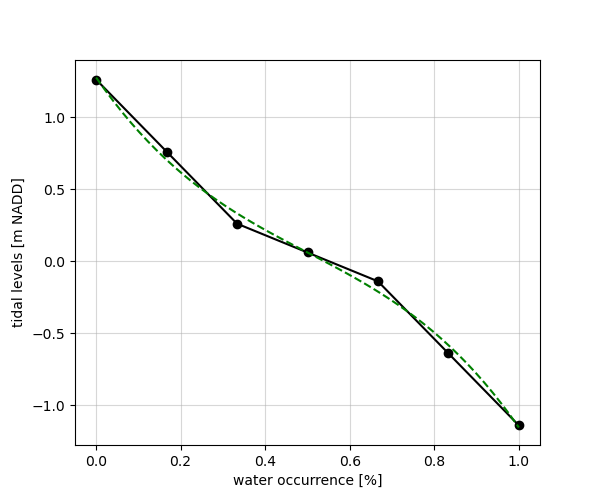

In [69]:
# fit model through the tidal indicators to obtain a calibration algorithm
# TODO: calibration with ICESat-2 data iso tidal indicators

# function to find r2 while polyfitting
def adjR(x, y, degree):
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))
    return r2

# retrieve R2 values
rlist = []
for i in range(7): # fit up to fifth degree polynomial
    rlist.append(adjR(np.linspace(1,0,len(tide_inds)), tide_inds, i)) # turn around 
rlist_c = [np.nan if round(i,3) == 1 or i == np.inf else i for i in rlist] # replace r2 equal 1 and inf (overfitted) with nan
spl = np.poly1d(np.polyfit(np.linspace(1,0,len(tide_inds)), tide_inds, np.nanargmax(rlist_c)))
rnd_vls = np.linspace(0, 1, 50)
print(spl, 'r2:', np.nanmax(rlist_c))

# make figure
plt.figure(figsize=(6,5))
plt.plot(np.linspace(1,0,len(tide_inds)), tide_inds, 'ko-')
plt.plot(rnd_vls, spl(rnd_vls), 'g--')
plt.grid(alpha=0.5)
plt.xlabel('water occurrence [%]')
plt.ylabel('tidal levels [m NADD]');

# from scipy import interpolate
# s = interpolate.UnivariateSpline(tide_inds, np.linspace(0,1,len(tide_inds)), k=4, s=1) # interpolated spline has s=0, zero smoothing
# xnew = np.linspace(np.min(tide_inds), np.max(tide_inds), 50)
# ynew = s(xnew)
# plt.plot(xnew, ynew, 'r--')

In [70]:
# TODO: get rid of tile boundaries... normalization over all tiles (DOS) within AOI..? see bottom https://www.openearth.nl/rws-bathymetry/2019.html
# or detrend (inspiration from JIP CALM) --> does not seem to work.. 
# from scipy import signal
# import pandas as pd
# import copy
#ws_copy = copy.deepcopy(ws)
#(ws_copy[np.logical_not(pd.isna(ws_copy))] = signal.detrend(ws_copy[np.logical_not(pd.isna(ws_copy))], type='constant'))

# now implemented normalization over all tiles, which resolves the depths better, but still have tile boundaries..

In [71]:
# retrieve mins and maxs across all tiles
mins =[]
maxs =[]
for tile, name in zip(tiles, tile_names):
   print(name)
   ws_band = tile.GetRasterBand(1) # water_score
   ws = ws_band.ReadAsArray()
   nodata = tile.GetRasterBand(1).GetNoDataValue()
   if nodata != None: # masked no data values if applicable
      ws = np.ma.masked_values(ws, nodata)

   print(np.nanpercentile(ws, 0.01), np.nanpercentile(ws, 99.99))

   mins.append(np.nanpercentile(ws, 0.01)) # maxima and minima might not be true min
   maxs.append(np.nanpercentile(ws, 99.99)) # maxima and minima might not be true max

t2021-01-01_2022-01-01.tif
-0.05631548096859636 0.15005637130188212


In [72]:
# scale data 0-1 over all tiles
#def NormalizeData(data): # scale 0-1 iso -0.05 - 0.15
#    return (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
def NormalizeData(data): # scale 0-1 iso -0.05 - 0.15
    return (data - -0.05) / (0.15 - -0.05)

# dataset scaling and calibration using tidal indicators
wp = [] # water probability
ie = [] # intertidal elevation 
for tile in tiles:
    #print(tile)
    ws_band = tile.GetRasterBand(1) # water_score
    ws = ws_band.ReadAsArray()
    gt = tile.GetGeoTransform()
    nodata = tile.GetRasterBand(1).GetNoDataValue()
    if nodata != None: # masked no data values if applicable
        ws = np.ma.masked_values(ws, nodata)

    # replace odd values
    ws[ws < -0.05] = -0.05
    ws[ws > 0.15] = 0.15

    ws_scaled = NormalizeData(ws)
    #ws_scaled = (ws - np.nanmin(mins)) / (np.nanmax(maxs) - np.nanmin(mins))
    #print(np.nanmin(ws_scaled), np.nanmax(ws_scaled), np.nanmean(ws_scaled), np.nanstd(ws_scaled)) # ws_band.GetStatistics(True, True) # [min, max, mean, std]

    # mask out land
    #ws_masked = np.ma.masked_array(ws_scaled, mask=ws_scaled<=0.05) # close to zero, probably non-water

    # calibrate water occurrence according to fitted model in tile above (one model for all tiles)
    SDBI = spl(ws_scaled)
    #print(np.nanmax(SDBI), np.nanmin(SDBI))

    # mask out land and deep water
    SDBI_masked = np.ma.masked_array(SDBI, mask=((SDBI<tide_inds[0]) | (SDBI>tide_inds[-1])))

    # assign tiles
    wp.append(ws_scaled)
    ie.append(SDBI_masked)

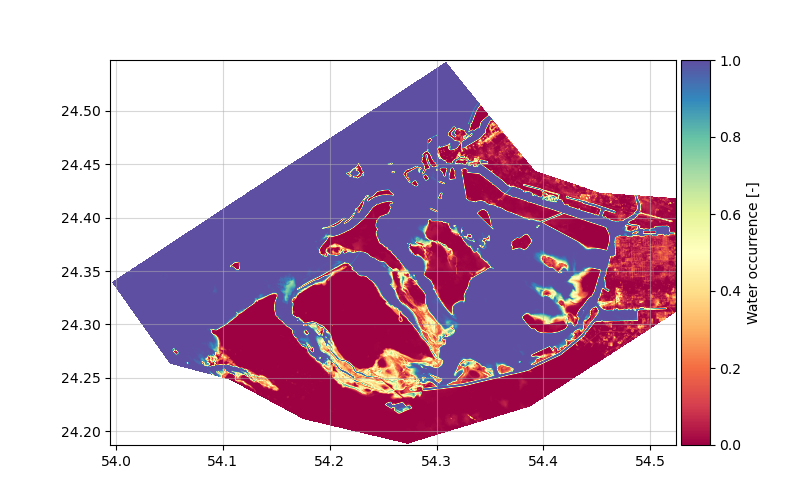

In [73]:
# water occurrence plot

sel_tile = 0
plt.clf() # prevent overflowing the memory

# extent of tile
ys, xs = ie[sel_tile].shape
ulx, xres, _, uly, _, yres = tiles[sel_tile].GetGeoTransform()
extent = [ulx, ulx+xres*xs, uly+yres*ys, uly] # left, right, bottom, top

# make plot
fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(wp[sel_tile], extent=extent, cmap=plt.cm.Spectral, vmin=0, vmax=1)
ax.grid(alpha=0.5)

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, shrink=.5, cax=cax)
#cb.ax.set_yticklabels(['0 - always land','0.2','0.4','0.6','0.8','1.0 - always water'])
cb.set_label('Water occurrence [-]')

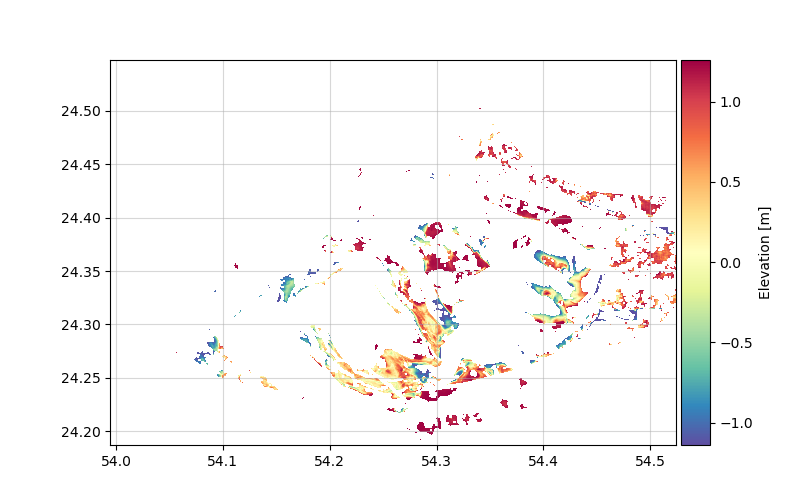

In [74]:
# elevation plot
#plt.close('all') # prevent overflowing the memory
plt.clf()

# make plot
fig, ax = plt.subplots(figsize=(8,5))
ax.grid(alpha=0.5)
im = ax.imshow(ie[sel_tile], extent=extent, cmap=plt.cm.Spectral_r)

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, shrink=.5, cax=cax)
cb.set_label('Elevation [m]')

In [75]:
# # Interactive map

# # TODO: take center of AOI input file if present, put in random coordinate and let user find a place and draw a polygon
# Map = geemap.Map(center=(24.33, 54.30), zoom=10) # initialize map with base in Hudayriat

# with open(os.path.join(main_fol, "AOI", project_name + ".geojson"), 'r') as f:
#     contents = geojson.loads(f.read())
# AoIee = ee.Geometry(contents["features"][0]["geometry"])

# # TODO: get rid of black outline with nan data
# Map.add_raster(tile_paths[sel_tile], band=1, vmin=-0.05, vmax=0.15, palette='viridis', nodata=np.nan, layer_name='water_score')

# Map.addLayer(AoIee, {}, "AoI")

# Map # show map

In [76]:
# export to local drive 

# construct and save tiff locally
for idx, (i, j, src) in enumerate(zip(tile_names, ie, tiles)):

    # fix to replace "non-existent mask" to match nan values
    temp = j.copy()
    temp[np.where(temp < tide_inds[0])] = np.nan 
    temp[np.where(temp > tide_inds[-1])] = np.nan

    # drive gdal operation
    driver = gdal.GetDriverByName("GTiff")
    WLtiff = driver.Create(os.path.join(main_fol, output_fol, "TIFF/intertidal", i),src.RasterXSize,src.RasterYSize,1,gdal.GDT_Float32 ,options=["COMPRESS=LZW"])
    WLtiff.SetGeoTransform(src.GetGeoTransform())
    srs = (osr.SpatialReference())  # construct spatial reference
    srs.ImportFromEPSG(4326)  # get crs
    WLtiff.SetProjection(srs.ExportToWkt())  # set projects (crs) of the tiff
    WLtiff.GetRasterBand(1).WriteArray(temp)  # write binary NDWI to the first band of the tiff
    WLtiff.FlushCache()  # saves tiff to disk
    WLtiff = None  # closes the file

In [77]:
# export to local drive

# construct and save XYZ data locally
for idx, (i, j, src) in enumerate(zip(tile_names, ie, tiles)):
    print(idx)

    # fix to replace "non-existent mask" to match nan values
    temp = j.copy()
    temp[np.where(temp < tide_inds[0])] = np.nan 
    temp[np.where(temp > tide_inds[-1])] = np.nan

    # extent of tile
    ys, xs = j.shape
    ulx, xres, _, uly, _, yres = src.GetGeoTransform()
    
    # construct the raster coords
    xdata = np.linspace(ulx+xres/2, ulx+xres*xs-xres/2, xs)
    ydata = np.flip(np.linspace(uly+yres*ys-yres/2, uly+yres/2, ys))
    xx, yy = np.meshgrid(xdata,ydata)

    # get rid of nan values and move to lists
    X = np.reshape(xx.flatten(), (len(xx.flatten()),1))
    Y = np.reshape(yy.flatten(), (len(yy.flatten()),1))
    Z = np.reshape(temp.flatten(), (len(temp.flatten()),1))
    xyz = np.concatenate((X, Y, Z), axis=1)
    xyz_nonan = xyz[~np.isnan(xyz).any(axis=1)]

    fmt = '% -2.9f', '% -2.9f', '% -2.9f'
    with open(os.path.join(main_fol, output_fol, "XYZ/intertidal", i.replace(".tif","_EPSG4326.xyz")), 'w') as ascii:
        np.savetxt(ascii, xyz_nonan, fmt=fmt, delimiter=' ')

0


In [513]:
# control output

# # import pandas as pd
# check_file = pd.read_table(os.path.join(main_fol, output_fol, "XYZ/intertidal", tile_names[1].replace(".tif","_EPSG4326.xyz")), delim_whitespace=True, names=['x', 'y', 'z'])

# plt.figure()
# plot = plt.scatter(check_file.x, check_file.y, s= 10, c = check_file.z, cmap='Spectral_r', vmin=-1.14, vmax=1.26) #
# plt.imshow(ie[1], extent=extent, cmap=plt.cm.Spectral_r, vmin=-1.14, vmax=1.26)